In [15]:
import torch
import torchvision
from torch.optim import Adam
from PIL import Image
from torchvision import transforms
from data_utils.pre_process import load_images_from_folder, load_images_and_labels, load_datasets
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
import torch
import pytest
from models.model_blocks import (
    UNetDecoderBlock,
    UNetEncoderBlock,
    UNetMidBlock,
    UNetDecoder,
    UNetEncoder
)
from models.unet import UNet

In [16]:
input_folder_path = "oxford-iiit-pet/images"
label_folder_path = "oxford-iiit-pet/annotations/trimaps"

input_images, label_images = load_images_and_labels(input_folder_path=input_folder_path,
                                                    label_folder_path=label_folder_path)

train_transforms = A.Compose([
    A.Resize(300, 300),
    A.HorizontalFlip(p=0.5),                  
    A.RandomCrop(height=256, width=256), 
    A.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                        max_pixel_value=255.0,
                        normalization="standard", # Default
                        p=1.0),
    A.ToTensorV2()                            
])

val_test_transforms = A.Compose([
    A.Resize(300, 300),
    A.HorizontalFlip(p=0.5),                  
    A.RandomCrop(height=256,width=256),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                normalization="standard", # Default
                p=1.0),
    A.ToTensorV2()                          
])

train_dataset, val_dataset, test_dataset = load_datasets(input_images, 
                                                            label_images, 
                                                            train_transforms,
                                                            val_test_transforms,
                                                            shuffle=False)

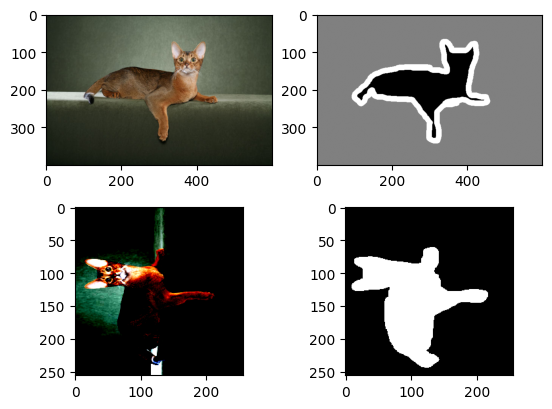

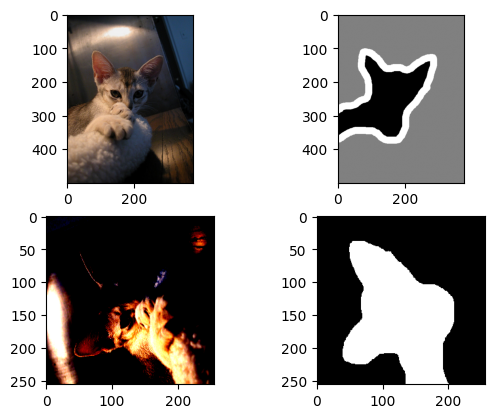

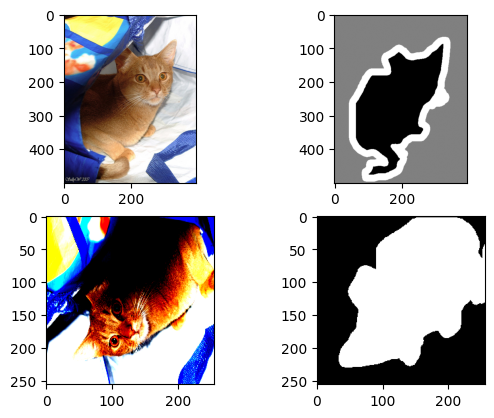

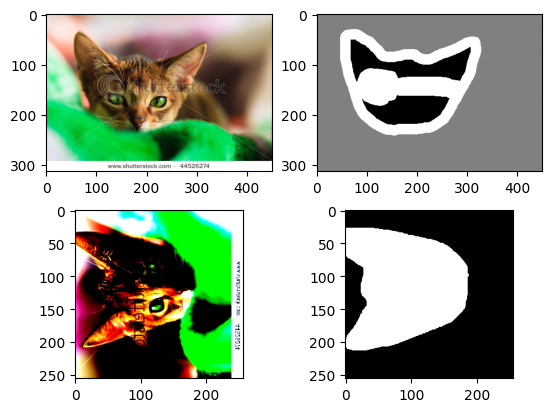

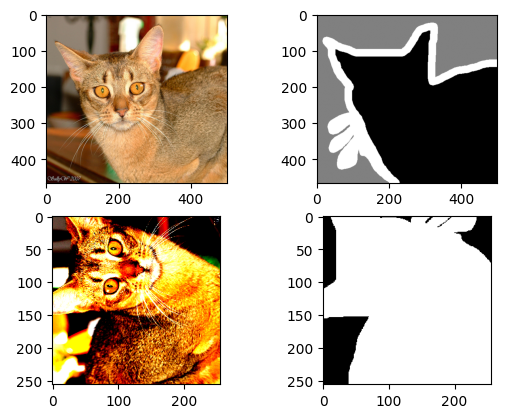

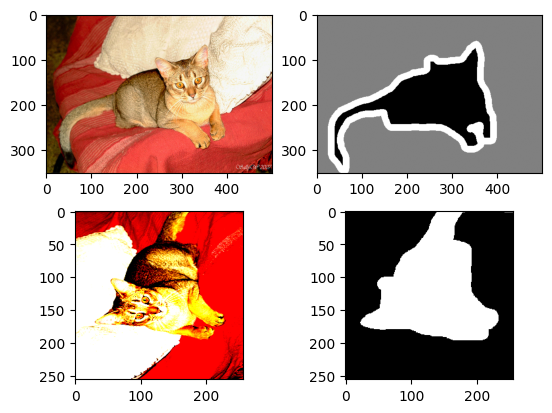

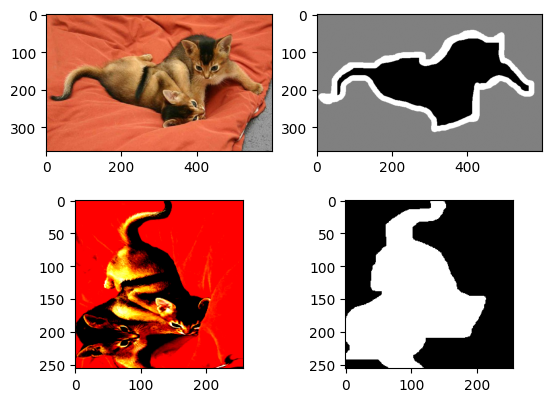

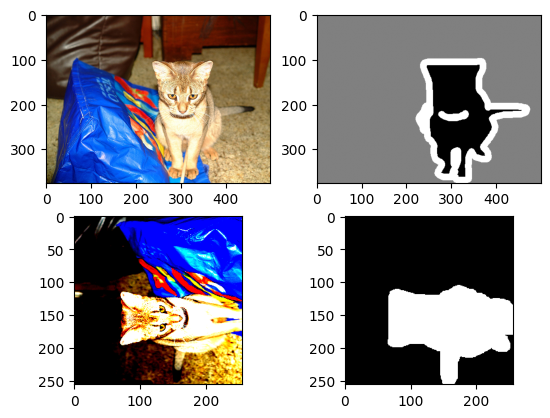

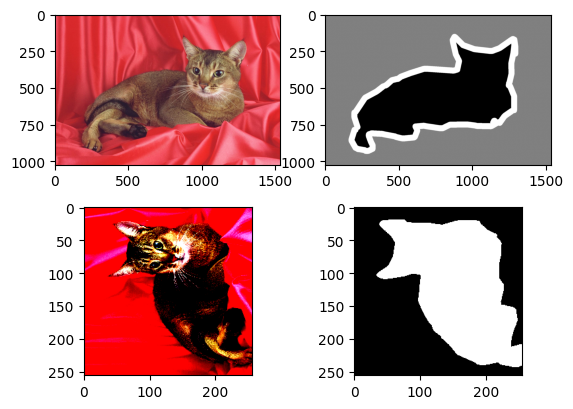

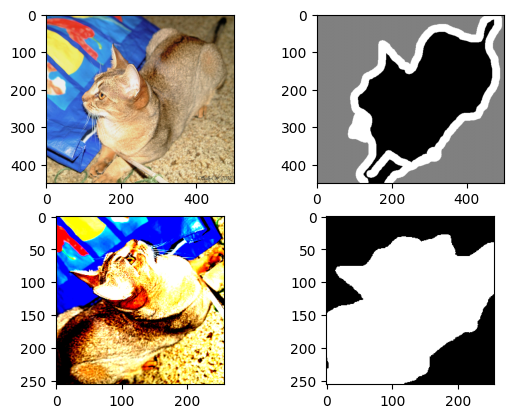

In [17]:
for i in range(10):
    fig, axes = plt.subplots(2,2)
    original_img, original_segment = input_images[i], label_images[i]
    trans_img, trans_segment = train_dataset.__getitem__(i)

    axes[0,0].imshow(original_img)
    axes[0,1].imshow(original_segment, cmap='gray')

    axes[1,0].imshow(np.clip(trans_img.T, 0, 1))
    axes[1,1].imshow(trans_segment.T, cmap='grey')

    plt.show()
    

In [26]:
x, y = train_dataset.__getitem__(0)

In [28]:
y.shape

torch.Size([256, 256])

In [32]:
torch.unsqueeze(x, 0).shape

torch.Size([1, 3, 256, 256])

In [33]:
unet = UNet(in_channels=3, 
            out_channels=64,
            kernel_size=3, 
            crop_sizes=[392, 200, 104, 56], 
            final_filters=1)

# x = torch.unsqueeze(x, 0)
y_hat = unet(torch.unsqueeze(x, 0))

In [37]:
torch.unsqueeze(torch.unsqueeze(y, dim = 0), dim = 0)

torch.Size([1, 1, 256, 256])

In [40]:
y

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [39]:
y_hat

tensor([[[[-0.1049, -0.1019, -0.1019,  ..., -0.1013, -0.1031, -0.1073],
          [-0.1115, -0.1089, -0.1098,  ..., -0.1096, -0.1078, -0.1079],
          [-0.1049, -0.1095, -0.1066,  ..., -0.1075, -0.1076, -0.0990],
          ...,
          [-0.1036, -0.1081, -0.1046,  ..., -0.1082, -0.1045, -0.0932],
          [-0.1059, -0.1052, -0.0947,  ..., -0.0948, -0.0989, -0.0951],
          [-0.1137, -0.1110, -0.1035,  ..., -0.1117, -0.1122, -0.1122]]]],
       grad_fn=<ConvolutionBackward0>)

In [38]:
torch.nn.functional.cross_entropy(torch.unsqueeze(torch.unsqueeze(y, dim = 0), dim = 0), y_hat)

tensor(-0., grad_fn=<DivBackward1>)

In [43]:
def binary_iou(pred, target, threshold=0.5, eps=1e-7):
    """
    pred:   (B, 1, H, W) logits or probabilities
    target: (B, 1, H, W) binary mask {0,1}
    """
    pred = torch.sigmoid(pred) if pred.dtype.is_floating_point else pred
    pred = (pred > threshold).bool()
    target = target.bool()

    intersection = (pred & target).sum(dim=(1,2,3))
    union = (pred | target).sum(dim=(1,2,3))

    iou = (intersection + eps) / (union + eps)

    # handle empty masks
    iou[union == 0] = 1.0

    return iou.mean()

In [57]:
def test_binary_iou():
    y_hat = torch.tensor([[[1,1,0]]])
    y = torch.tensor([[[1,1,1]]])

    acc = binary_iou(torch.unsqueeze(y_hat, 0), torch.unsqueeze(y, 0))

    assert((float(acc) - 0.33) < 0.001)
t = test_binary_iou()

AssertionError: 

In [61]:
float(t) - 0.666

0.0006666865348815554